XGBoost Modelling

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
from expected_score_model.evaluation.glm_evaluator import LogisticEvaluator

In [3]:
from expected_score_model.preprocessing.preprocessor import ExpectedScorePreprocessor
from expected_score_model.preprocessing.response import create_expected_score_response

Data

In [4]:
chains = pd.read_csv('/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/AFL_Chains.csv')

In [5]:
chains = create_expected_score_response(chains)

In [6]:
chains.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal
0,NaN,1,Brisbane,centreBounce,turnover,1.0,0.0,Centre Bounce,NaN,NaN,NaN,1.0,0.0,0.0,0.0,Sydney,Brisbane,right,141.0,160.0,NaN,NaN,AFL_2024_F4_Sydney_Brisbane,NaN,miss,0,1,0,0
1,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Hard Ball Get,NaN,NaN,NaN,2.0,8.0,-12.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
2,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,3.0,8.0,-13.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
3,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball Received,NaN,NaN,NaN,4.0,10.0,-19.0,-13.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0
4,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,5.0,10.0,-19.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0


Preprocessing

In [7]:
xs_preproc = ExpectedScorePreprocessor()
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [8]:
result_map = {
    'behind': 0,
    'goal': 1,
    'miss': 2
}
y_shots = y_shots.map(result_map)

In [9]:
X_shots.head(1)

,Description_grouped,angle,angle_degrees,chain_duration,description_grouped_0,description_grouped_1,description_grouped_2,description_grouped_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3
47,Kick,0.321751,18.434949,68.0,Kick,Mark,Kick,Other,37.947332,3.636199,8.246211,1440.0,36.0,12.0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0


Feature Selection

In [10]:
selected_features = [
    'distance', 'angle', 'set_shot', 'distance_since_last_action'
    ]
X_shots_selected = X_shots[selected_features]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_shots_selected, y_shots, test_size=0.2, random_state=42)

Fitting Model

In [12]:
lr = LogisticRegression(C=1.0)
lr.fit(X_train, y_train)

LogisticRegression()

Get Predictions

In [13]:
probas = lr.predict_proba(X_test)

In [14]:
class_names = list(result_map.keys())
class_probabilities = {f'predicted_proba_{class_names[i]}': probas[:, i] for i in range(len(class_names))}

In [15]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = np.array([np.argmax(x) for x in probas])

In [16]:
score = chains.loc[y_test.index, 'score']
goal = chains.loc[y_test.index, 'goal']
behind = chains.loc[y_test.index, 'behind']
miss = chains.loc[y_test.index, 'miss']

actuals_binary = np.array(chains.loc[y_test.index, class_names])

In [17]:
score.sum(), predicted_score.sum()

(27917, 27541.710681215925)

Model Evaluation

In [18]:
model_eval = ModelEvaluator(model = lr)

In [19]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.333373134328358, 'predicted': 3.2885624693989164}

In [20]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])

{'actual': 0.4982686567164179, 'predicted': 0.49042789935048725}

In [21]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])#, model_eval.averages(actual = behind, predicted = class_probabilities_cal['predicted_cal_proba_behind'])

{'actual': 0.3437611940298507, 'predicted': 0.3459950732959931}

In [22]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])#, model_eval.averages(actual = miss, predicted = class_probabilities_cal['predicted_cal_proba_miss'])

{'actual': 0.15797014925373135, 'predicted': 0.16357702735351967}

Modelled Features

In [23]:
lr.feature_names_in_

array(['distance', 'angle', 'set_shot', 'distance_since_last_action'],
      dtype=object)

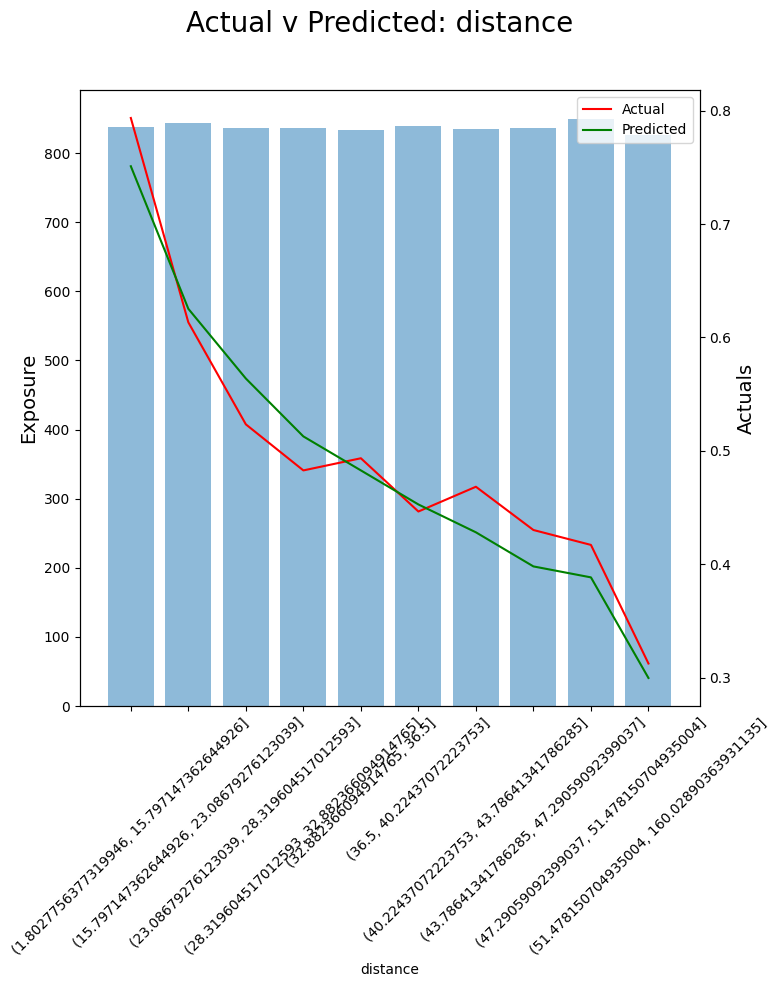

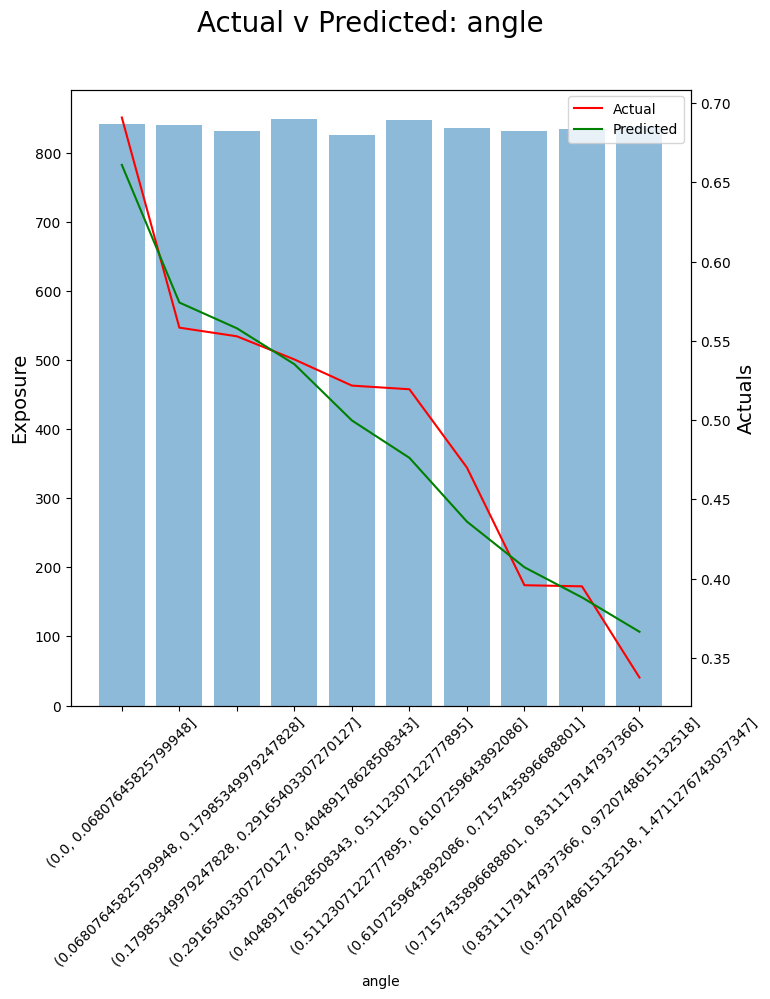

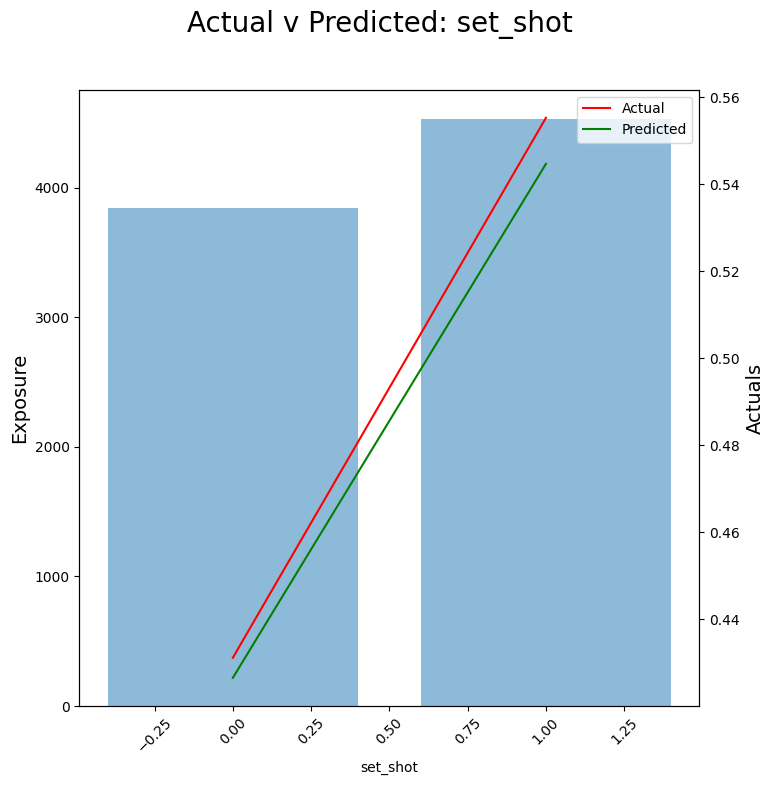

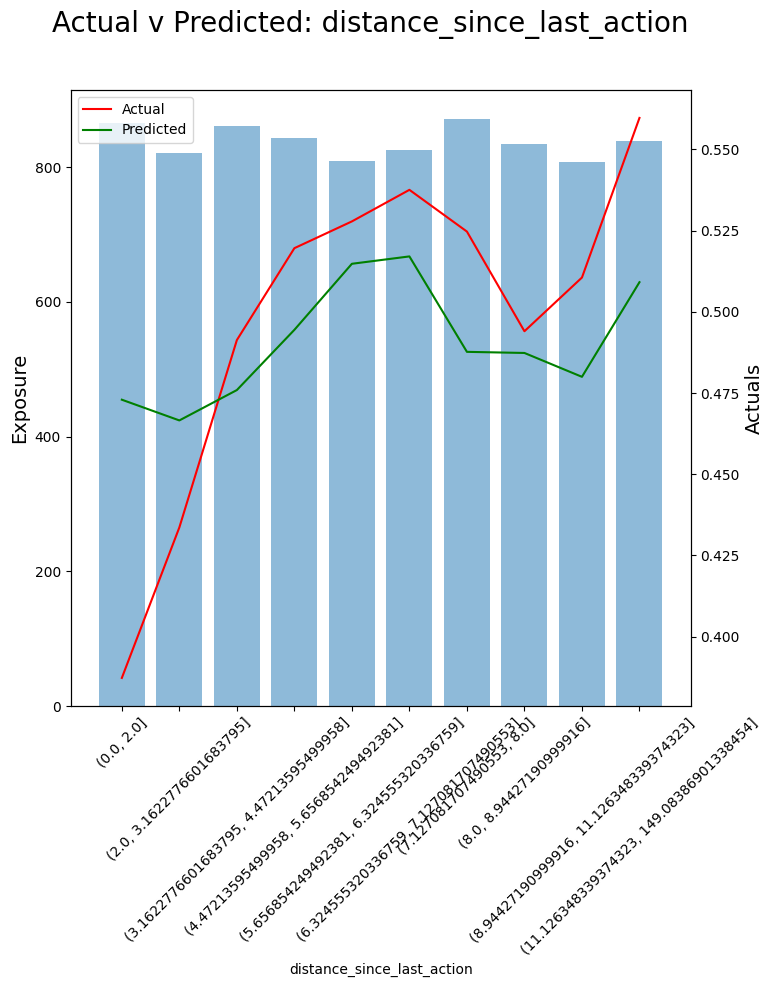

In [24]:
for feature in lr.feature_names_in_:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_test[feature], feature_name = feature)

Extra Features

In [25]:
# candidate_features = sorted(list(set(X_shots.columns) - set(X_shots_selected)))
# for feature in candidate_features:
#     fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots.loc[X_test.index][feature], feature_name = feature)

Classification

In [26]:
multi_class_model_eval = ClassificationModelEvaluator(model = lr, classification_type='multi')

In [27]:
actual_label = y_test
predicted_label = predicted_result

In [28]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.6212313459866502,
 'class_1': 0.6202637374834058,
 'class_2': 0.3948804404769392}

In [29]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.21723637129816575,
 'class_1': 0.2158992334020572,
 'class_2': 0.12274530857358704}

Needs calibration

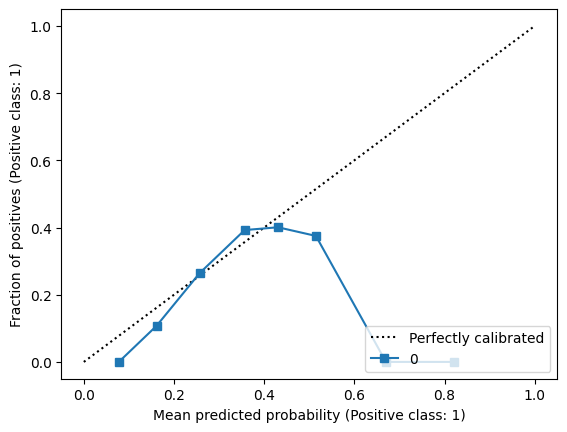

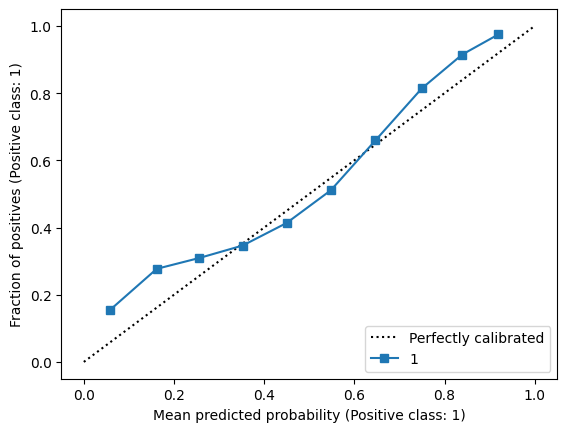

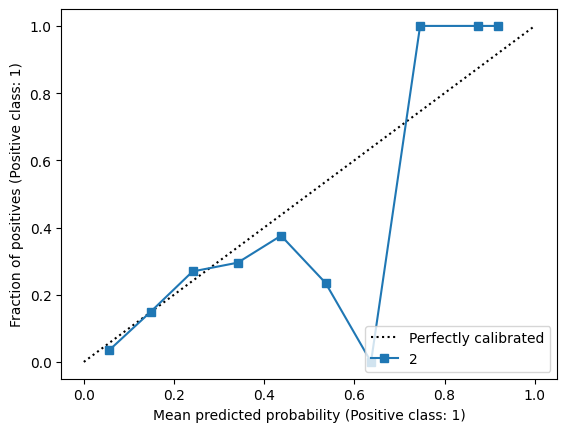

In [30]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = probas, nbins=10) 

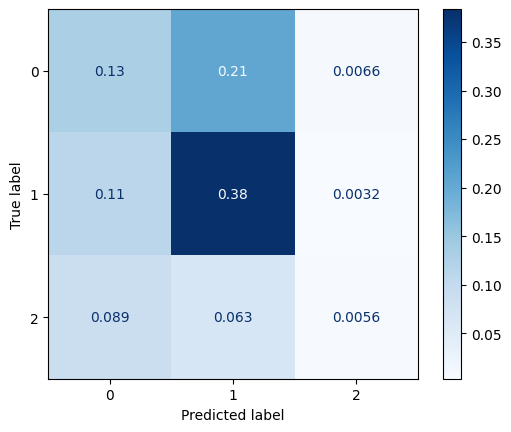

In [31]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [32]:
regression_model_eval = RegressionModelEvaluator(model = lr)

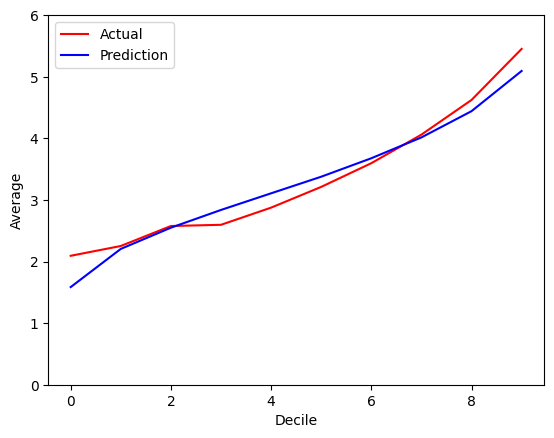

In [33]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

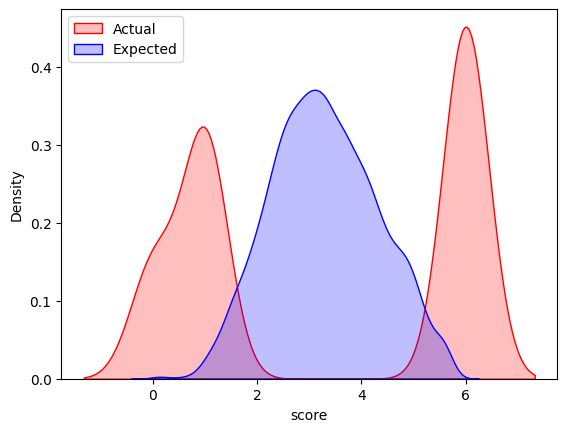

In [34]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

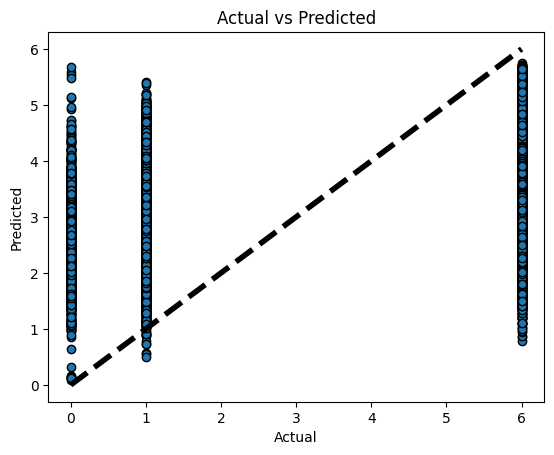

In [35]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

Logistic Regression Evaluation

In [36]:
lr_evaluator = LogisticEvaluator(lr_model = lr, evaluator = ClassificationModelEvaluator)

Feature Importance

In [37]:
lr_evaluator.get_feature_importance()

,Feature,Coefficient_0,Coefficient_1,Coefficient_2
0,distance,0.006996,-0.039618,0.032622
1,angle,0.114068,-0.967281,0.853213
2,set_shot,-0.072983,0.745898,-0.672914
3,distance_since_last_action,0.006043,0.013589,-0.019632


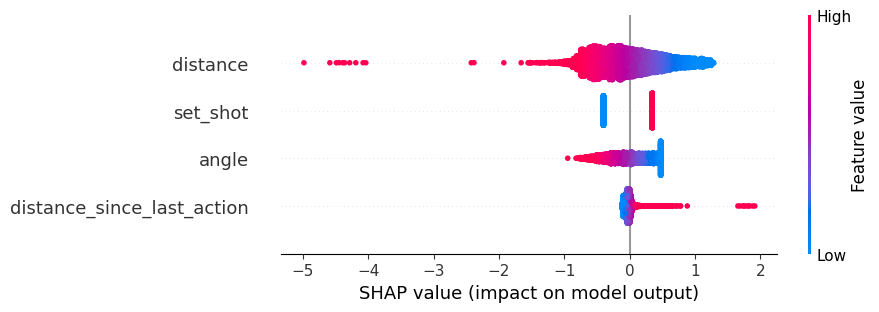

In [38]:
lr_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=1, max_display=10)

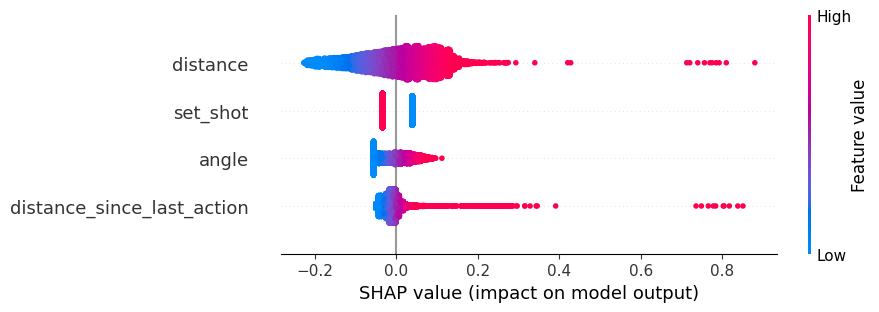

In [39]:
lr_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=0, max_display=10)

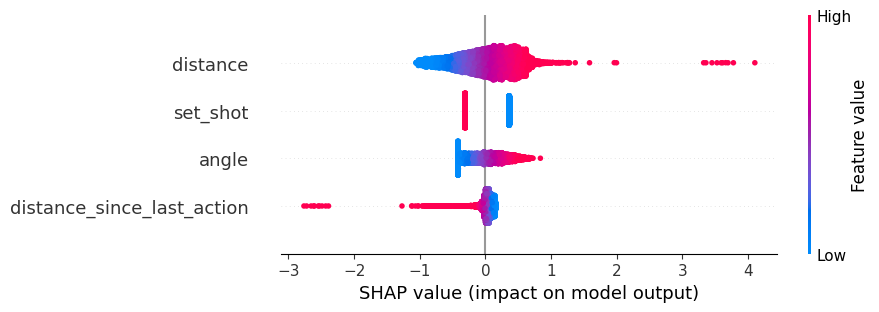

In [40]:
lr_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=2, max_display=10)

Export (or Upload) Predictions

In [41]:
result_map_rev = {0: 'behind', 1: 'goal', 2: 'miss'}

Decided not to use calibrated as simpler and raw probas look calibrated already.

In [42]:
shots = chains.loc[X_shots.index]
shots['predicted_result'] = lr.predict(X_shots[selected_features]).flatten()
shots[[f'{result_map_rev[x]}_probas' for x in lr.classes_]] = lr.predict_proba(X_shots[selected_features])
shots['xscore'] = shots['goal_probas']*6 + shots['behind_probas']
shots = pd.concat([shots, X_shots], axis=1)
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,Description_grouped,angle,angle_degrees,chain_duration,description_grouped_0,description_grouped_1,description_grouped_2,description_grouped_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3
47,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,1,0.290735,0.631943,0.077322,4.082393,Kick,0.321751,18.434949,68.0,Kick,Mark,Kick,Other,37.947332,3.636199,8.246211,1440.0,36.0,12.0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0
111,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,0,0.412785,0.403710,0.183505,2.835044,Kick,0.942000,53.972627,57.0,Kick,Mark,Kick,Other,40.804412,3.708790,8.944272,1665.0,24.0,33.0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0
195,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,1,0.367687,0.453189,0.179124,3.086823,Kick,0.753151,43.152390,8.0,Kick,Ball Get,Gather,Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0
206,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,1,0.310794,0.593302,0.095904,3.870606,Kick,0.762147,43.667780,20.0,Kick,Free,Free,Kick,30.413813,3.414897,7.615773,925.0,22.0,21.0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0
217,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,0,0.450177,0.241723,0.308101,1.900513,Kick,0.767856,43.994914,18.0,Kick,Other,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0


In [43]:
shots.to_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_lr.csv", index=False)

Export Joblib

In [44]:
import joblib

In [45]:
joblib.dump(lr, '/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/lr_model.joblib')

['/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/lr_model.joblib']